In [1]:
import datasets
import models
import exploitations
import experiment_definition as ed
from config import load_config
import time
import os
import os.path as osp
#import mailer
import random
import traceback
import dill
import gc
import sys
import utils
import cv2
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(asctime)s: %(message)s')
logger = logging.getLogger(__name__)

import torch
import torch.nn as nn
from torch.autograd import Function
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU
from torch.utils.data import DataLoader
from segmentation_models_pytorch.utils.losses import DiceLoss
from torchinfo import summary
import albumentations as album
from config import load_config

config = load_config()

In [2]:
notebook = True
config["experiment_name"]="Fullcourt"
config["experiment_id"]=12
config["dataset_name"]="Fullcourt"
config["model_name"]="Deeplabv3plus"
config['dataset_type']="Semanticsegmentation"
config['input_height']=720
config['input_width']=1280
config['shuffle']=True
config['augmentation_colour_format']='hsv'
config['augmentation_spatial']=True
config['augmentation_colour']=True
config['split_ratio']=0.9
config['encoder']="resnet50"
config['encoder_weights']="imagenet"
config['activation']="softmax2d"
config['optimizer']="adam"
config['learning_rate']=0.0001
config['loss_function']="dice_loss"
config['n_epochs']=100
config['batch_size']= 16
config['stride']=8
config['freeze_encoder']=False #False if training from scratch
config['experiment_path']=ed.get_experiment_path(config)
config['fineTune']=False
config['overlay_opacity']=0.7
config['exploitation_name']='Experiment_10'

In [3]:
class WeightedDiceLoss(torch.nn.Module):
    def __init__(self, weights):
        super(WeightedDiceLoss, self).__init__()
        self.weights = weights
        self.name = "WeightedDiceLoss"  # Add this line

    def forward(self, output, target):
        smooth = 1.0
        loss = 0.0

        # Loop over each class
        for i, weight in enumerate(self.weights):
            iflat = output[:, i, ...].contiguous().view(-1)
            tflat = target[:, i, ...].contiguous().view(-1)
            intersection = (iflat * tflat).sum()

            dice = (2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)
            loss += weight * (1 - dice)

        return loss


In [4]:
class NotebookDataset(datasets.TennisDataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def get_class(self,class_names=None):
        class_names = ['background','full_court']
        super().get_class(class_names)


In [5]:
class NotebookModel(models.Deeplabv3plusModel):
    def __init__(self, dataset, **kwargs):
        super().__init__(dataset, **kwargs)

    # def prepare(self):
    #     super().prepare()
    #     print(str(summary(self.model, input_size=(self.batch_size, 3, self.input_height, self.input_width), verbose=True)))
    #
    # def get_batch_size(self):
    #     self.batch_size=2

    def setup_train(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # explain why the weights are like this
        class_weights = torch.FloatTensor([1.0, 3.0]).to(self.device)
        if self.loss_function == "dice_loss":
            #self.loss = DiceLoss()
            self.loss = WeightedDiceLoss(class_weights)
        self.metrics = [
            IoU(threshold=0.5),
        ]
        if self.optimizer == "adam":
            self.train_optimizer = torch.optim.Adam([
                dict(params=self.model.parameters(), lr=self.learning_rate)
            ])

        if self.optimizer == "sgd":
            self.train_optimizer = torch.optim.SGD(
                params=self.model.parameters(), lr=self.learning_rate
            )
        logger.info("Training setted up")

    def get_results(self, config):
        super(models.Deeplabv3plusModel,self).get_results(config)
        #config["stride"] = self.stride
        config["saved_epoch"] = self.saved_epoch
        config["train_miou"] = self.train_miou
        config["valid_miou"] = self.valid_miou
        #config["test_miou"] = self.test_miou
        config["train_dice_loss"] = self.train_dice_loss
        config["valid_dice_loss"] = self.valid_dice_loss
        #config["test_dice_loss"] = self.test_dice_loss



In [6]:
class NotebookExploitation(exploitations.TennisExploitation):
    def __init__(self, model, dataset, **kwargs):
        super().__init__(model,dataset, **kwargs)

class Notebook2Exploitation(exploitations.TennisExploitation):
    def __init__(self, model, dataset, **kwargs):
        super().__init__(model,dataset, **kwargs)

In [7]:
def get_dataset(config,notebook=True):
    class_name = config["dataset_name"].capitalize() + "Dataset"
    class_ = NotebookDataset if notebook else getattr(datasets, class_name)
    class_args = dict({key: config[key] for key in ed.dataset_keys})
    return class_(**class_args)

def get_model(config, dataset, notebook=True):
    class_name = config["model_name"].capitalize() + "Model"
    class_ = NotebookModel if notebook else getattr(models, class_name)
    class_args = dict({key: config[key] for key in ed.model_keys})
    return class_(dataset, **class_args)

def get_exploitation(config, model, dataset, notebook=True):
    class_name = config["dataset_type"].capitalize() + "Exploitation"
    class_ = NotebookExploitation if notebook else getattr(exploitations, class_name)
    class_args = dict({key: config[key] for key in ed.exploitation_keys})
    return class_(model, dataset, **class_args)

In [8]:
def run_training_experiment(config):
    dataset = get_dataset(config,notebook)
    dataset.prepare()

    model = get_model(config, dataset,notebook)
    model.prepare()
    model.train()
    #model.test()
    model.unload() #unload() method to release the model from memory

    with open(osp.join(config["experiment_path"], "dumps", "dataset.pickle"), 'wb') as dataset_file:
        dill.dump(dataset, dataset_file)
    with open(osp.join(config["experiment_path"], "dumps", "model.pickle"), 'wb') as model_file:
        dill.dump(model, model_file)

    del dataset, model
    gc.collect()
    torch.cuda.empty_cache()


def run_results_experiment(config,notebook=True):
    with open(osp.join(config["experiment_path"], "dumps", "dataset.pickle"), 'rb') as dataset_file:
        dataset = dill.load(dataset_file)
    with open(osp.join(config["experiment_path"], "dumps", "model.pickle"), 'rb') as model_file:
        model = dill.load(model_file)

    exploitation = get_exploitation(config, model, dataset, notebook)
    exploitation.prepare_exploitation()
    exploitation.generate_outputs()
    #exploitation.get_results(config)

    del dataset, model, exploitation
    gc.collect()
    torch.cuda.empty_cache()
    return config

def setup_experiment(config,onlyResults):
    experiment_path = ed.get_experiment_path(config)
    if onlyResults:
        if not osp.exists(experiment_path):
            onlyResults = False

    if not onlyResults:
        if osp.exists(experiment_path):
            os.rename(experiment_path, experiment_path + "_old" + str(random.randint(0, 1000)))
        os.makedirs(experiment_path)
        os.makedirs(osp.join(experiment_path, "logs"))
        os.makedirs(osp.join(experiment_path, "dumps"))
        os.makedirs(osp.join(experiment_path, "checkpoints"))
    config["experiment_path"] = experiment_path

def run_experiment(config, mail=True, onlyResults=False):
    experiment_start_time = time.time()

    setup_experiment(config,onlyResults)
    experiment_path = config["experiment_path"]

    try:
        if not onlyResults:
            run_training_experiment(config)
        time.sleep(0.5)
        result_config = run_results_experiment(dict(config),notebook)

    except Exception as e:
        error_msg = type(e).__name__ + "\n" + traceback.format_exc()
        print(error_msg)
        config["error"] = error_msg
        os.rename(experiment_path, experiment_path + "_error" + str(random.randint(0, 1000)))
    except KeyboardInterrupt as k:
        error_msg = type(k).__name__
        config["error"] = error_msg
        os.rename(experiment_path, experiment_path + "_error" + str(random.randint(0, 1000)))
        raise KeyboardInterrupt
    else:
        print(f"Experiment {result_config['experiment_id']} passed without errors")
        result_config["completed"] = True
        result_config["error"] = ""
        config = result_config

    print("\n" + "-" * 50 + "\n")
    config['experiment_elapsed_time'] = time.time() - experiment_start_time

    if mail:
        mailer.send_mail(config)
        print("Mail with results sent")

    print(config)

2023-12-18 12:44:21,266: Experiment number 12
2023-12-18 12:44:21,266: NotebookDataset instance created
2023-12-18 12:44:21,266: Dataset temporary folders created
2023-12-18 12:44:21,271: Class names: ['background', 'full_court']
2023-12-18 12:44:21,271: Class ids: [0, 1]
2023-12-18 12:44:21,272: Class colour palette: [[0, 0, 0], [255, 255, 255]]
2023-12-18 12:44:23,566: Dataset splitted successfully into train/valid sets
2023-12-18 12:44:23,566: Visual datasets built
2023-12-18 12:44:23,566: ----------------------------------------
2023-12-18 12:44:23,582: NotebookModel instance created
2023-12-18 12:44:23,883: Model created
2023-12-18 12:44:23,883: Output stride: 16
2023-12-18 12:44:45,659: Gpu batch size: 16
2023-12-18 12:44:45,659: Batch size after gpu check: 16
2023-12-18 12:44:45,659: Preprocessed datasets built
2023-12-18 12:44:45,659: Dataset loaders setted up
2023-12-18 12:44:45,675: Training setted up
2023-12-18 12:44:45,759: Started training experiment 12
2023-12-18 12:44:45

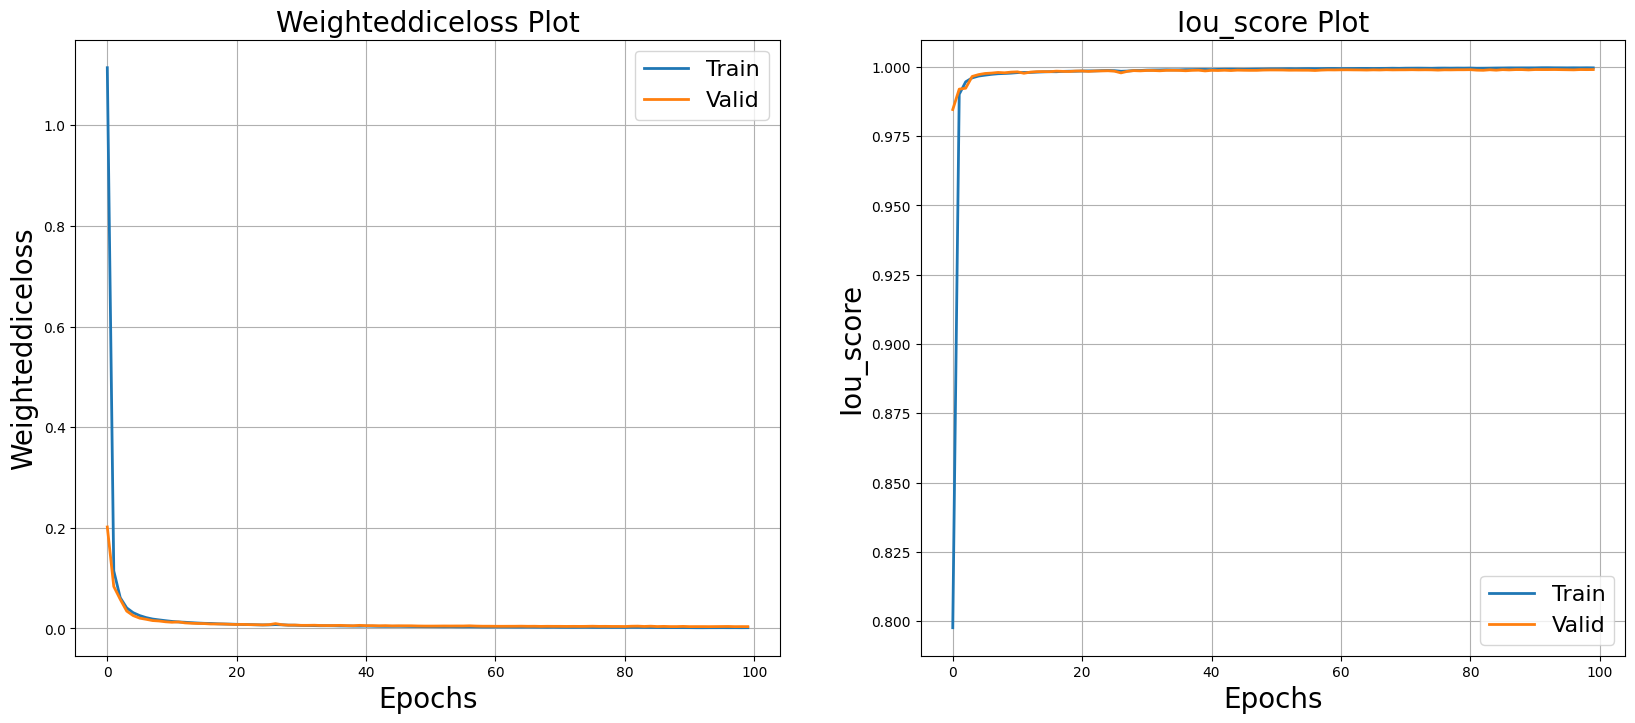

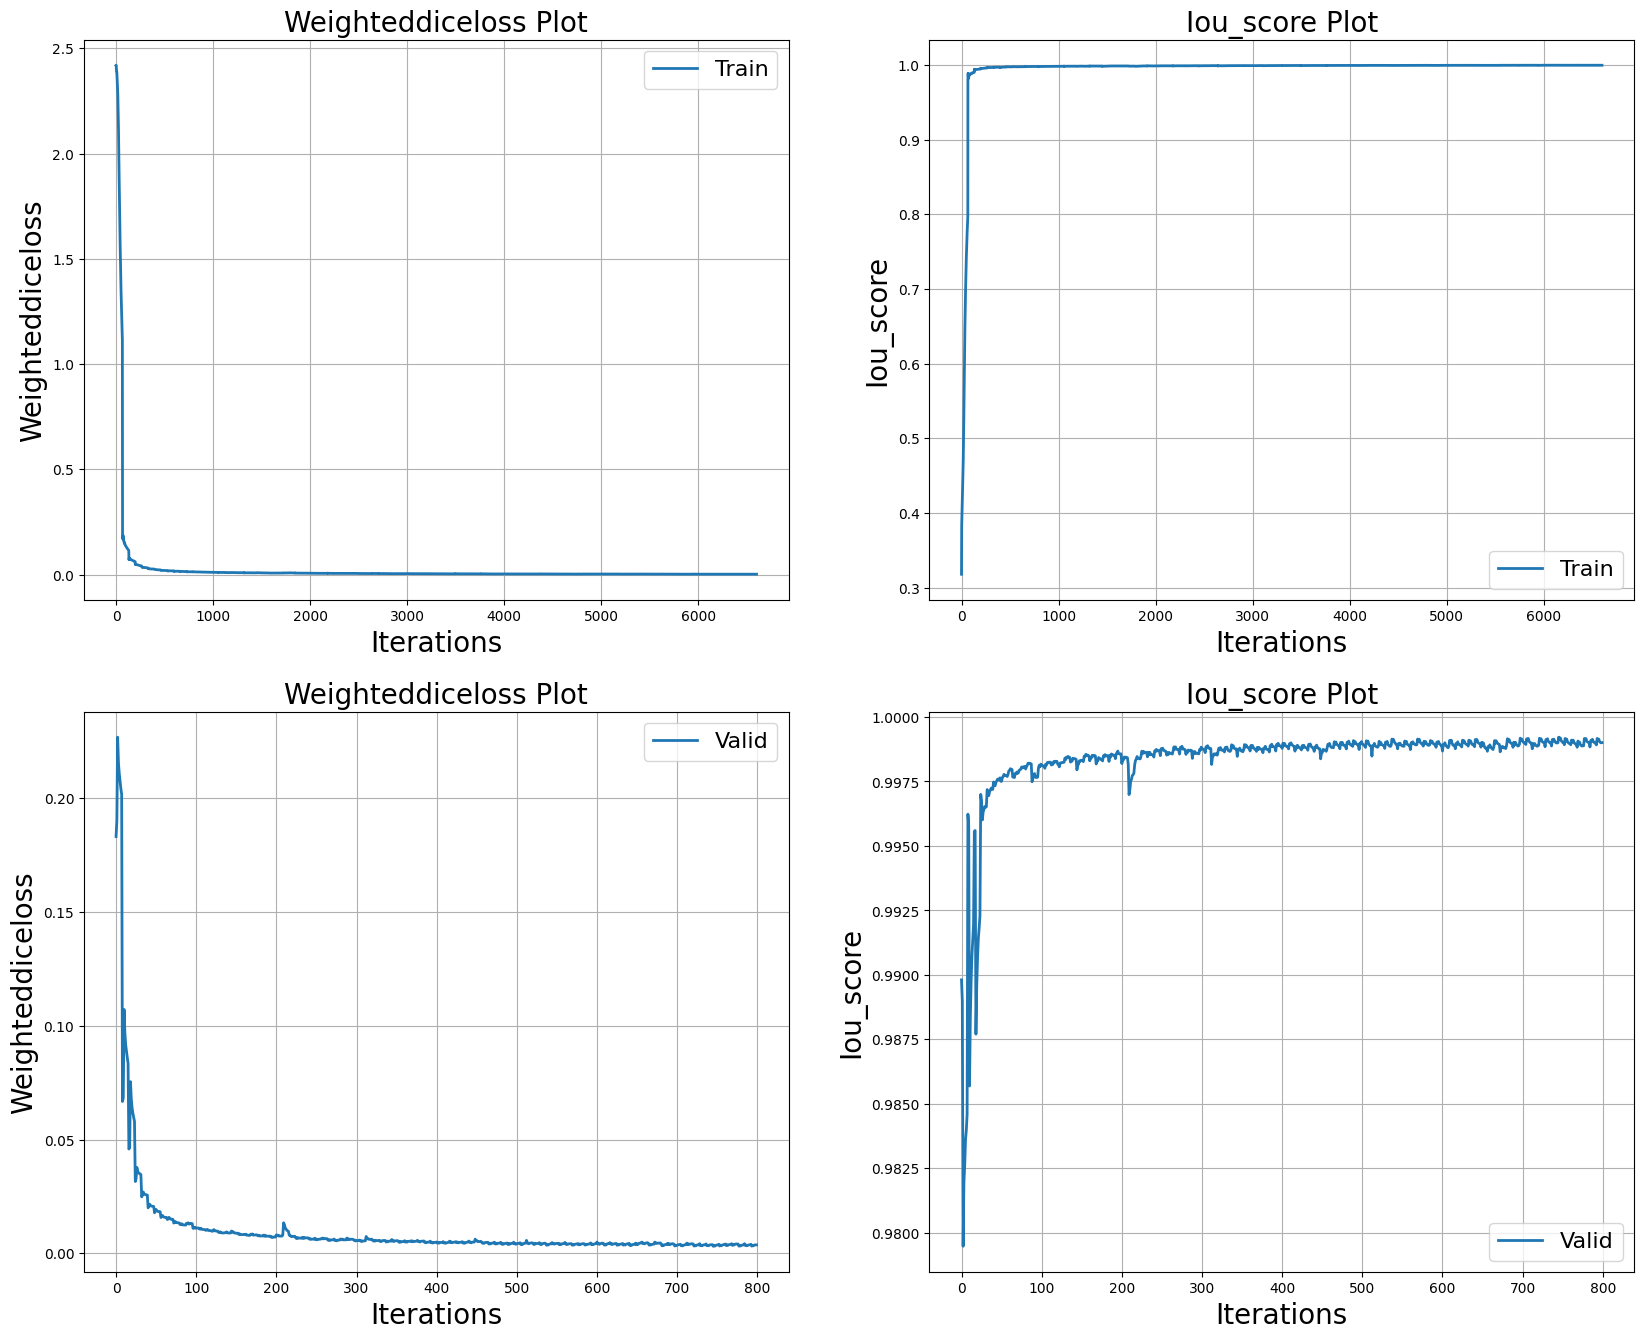

In [9]:
run_experiment(config,mail=False, onlyResults=False)